# 📄 Introduction for EDA Notebook

As part of the AIAP Batch 20 Technical Assessment, this notebook addresses Task 1: Exploratory Data Analysis (EDA). The goal is to analyze the dataset provided by AI-Vive-Banking, which contains client attributes and direct marketing campaign data.

The primary objective is to understand the patterns and factors influencing whether a client subscribes to a term deposit, helping the bank improve marketing efficiency. This notebook will follow a structured EDA workflow:

* Data loading and inspection — extract data from the provided SQLite database (bmarket.db) and load it into pandas DataFrames.

* Data cleaning and preprocessing — check for missing values, data types, and basic integrity.

* Exploratory analysis — summarize key statistics, visualize distributions, and examine relationships between features and subscription outcomes.

* Insights and conclusions — highlight important findings that will inform the machine learning pipeline design.

The notebook aims to communicate these findings clearly, using meaningful visualizations and well-documented reasoning to support further predictive modeling in Task 2.

## 📥 Data Loading and Inspection

We began by downloading the provided SQLite database (bmarket.db) using Python to ensure the process is reproducible.

Using sqlite3, we connected to the database and queried its schema to list all available tables. Each table was then loaded into a pandas DataFrame, allowing us to preview the data structure and content with head().

This step gave us an initial understanding of the dataset’s layout and key variables, setting the stage for data cleaning and deeper exploration.

In [ ]:
import requests
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


# Download the SQLite database
url = 'https://techassessment.blob.core.windows.net/aiap20-assessment-data/bmarket.db'
db_filename = 'bmarket.db'

response = requests.get(url)
with open(db_filename, 'wb') as f:
    f.write(response.content)

# Connect to the SQLite database
conn = sqlite3.connect(db_filename)

# Get the list of tables
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(tables_query, conn)
# Load each table into a pandas DataFrame
for table_name in tables['name']:
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)

# Close the connection when done
conn.close()

df.head(10)

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status
0,32885,57 years,technician,married,high.school,no,no,yes,Cell,1,999,no
1,3170,55 years,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,32207,33 years,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,9404,36 years,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,14021,27 years,housemaid,married,high.school,no,None,no,Cell,2,999,no
5,17202,58 years,retired,married,professional.course,no,None,yes,Cell,1,999,no
6,880,48 years,services,married,high.school,unknown,yes,no,Telephone,1,999,no
7,23758,150 years,admin.,divorced,university.degree,unknown,yes,None,Cell,7,999,no
8,10822,24 years,entrepreneur,married,university.degree,no,None,None,telephone,4,999,no
9,14356,36 years,technician,divorced,professional.course,no,yes,yes,Cell,4,999,no


## Data cleaning and preprocessing

In this section of the notebook, we will perform an initial data inspection to assess whether any preprocessing steps are required. Upon examining the DataFrame and its data types, we observe that the Client Id is currently treated as a numeric field, and the age column contains string values that could interfere with our visualizations. We will apply the necessary transformations to address these issues.

In [ ]:
df.dtypes

,0
Client ID,int64
Age,object
Occupation,object
Marital Status,object
Education Level,object
Credit Default,object
Housing Loan,object
Personal Loan,object
Contact Method,object
Campaign Calls,int64


In [ ]:
df['Age'] = df['Age'].astype(str).str.replace(' years', '', regex=False).astype(float)
# 🔧 Convert categorical columns to 'category' dtype
categorical_cols = ['Client ID', 'Occupation', 'Marital Status', 'Education Level',
                    'Credit Default', 'Housing Loan', 'Personal Loan',
                    'Contact Method', 'Subscription Status']

for col in categorical_cols:
    df[col] = df[col].astype('category')


In [ ]:
# 🔍 Initial inspection
print("✅ Data Information")
print(df.info())

✅ Data Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Client ID              41188 non-null  category
 1   Age                    41188 non-null  float64 
 2   Occupation             41188 non-null  category
 3   Marital Status         41188 non-null  category
 4   Education Level        41188 non-null  category
 5   Credit Default         41188 non-null  category
 6   Housing Loan           16399 non-null  category
 7   Personal Loan          37042 non-null  category
 8   Contact Method         41188 non-null  category
 9   Campaign Calls         41188 non-null  int64   
 10  Previous Contact Days  41188 non-null  int64   
 11  Subscription Status    41188 non-null  category
dtypes: category(9), float64(1), int64(2)
memory usage: 2.7 MB
None


We can observe the impact of the transformation by noting the updated data types. Next, we will proceed to check for duplicates and missing values.

In [ ]:
print("\n✅ Summary statistics")
print(df.describe(include='all'))


✅ Summary statistics
        Client ID           Age Occupation Marital Status    Education Level  \
count     41188.0  41188.000000      41188          41188              41188   
unique    41188.0           NaN         12              4                  8   
top       41188.0           NaN     admin.        married  university.degree   
freq          1.0           NaN      10422          24928              12168   
mean          NaN     51.231572        NaN            NaN                NaN   
std           NaN     34.708486        NaN            NaN                NaN   
min           NaN     17.000000        NaN            NaN                NaN   
25%           NaN     33.000000        NaN            NaN                NaN   
50%           NaN     40.000000        NaN            NaN                NaN   
75%           NaN     51.000000        NaN            NaN                NaN   
max           NaN    150.000000        NaN            NaN                NaN   

       Credit Def

In [ ]:
# 🔎 Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_report = pd.DataFrame({'Count': missing_values, 'Percentage': missing_percentage})
print("\n✅ Missing values report:\n", missing_report)



✅ Missing values report:
                        Count  Percentage
Client ID                  0    0.000000
Age                        0    0.000000
Occupation                 0    0.000000
Marital Status             0    0.000000
Education Level            0    0.000000
Credit Default             0    0.000000
Housing Loan           24789   60.185005
Personal Loan           4146   10.066039
Contact Method             0    0.000000
Campaign Calls             0    0.000000
Previous Contact Days      0    0.000000
Subscription Status        0    0.000000


We can now observe that the Housing Loan column has approximately 60% missing values, while the Personal Loan column has about 10% missing values. Given the difference in missing value proportions, we need to handle the NaNs using tailored strategies. For the column with 60% missing values, we will introduce a new category labeled “Unknown,” whereas for the column with 10% missing values, we will impute using the mode.

In [ ]:
df['Housing Loan'] = df['Housing Loan'].cat.add_categories('Unknown').fillna('Unknown')
mode_value = df['Personal Loan'].mode()[0]
df['Personal Loan'] = df['Personal Loan'].fillna(mode_value)

This approach is more effective because it takes into account the underlying distribution and proportion of missing values in each column, allowing for more appropriate and meaningful imputation. For the column with 60% missing data, using the mode would risk distorting the distribution and introducing bias, as the imputed value would dominate the variable and potentially mislead the analysis or model. By instead creating a new “Unknown” category, we preserve the information that these values were originally missing, which can be valuable for both descriptive insights and predictive modeling. On the other hand, for the column with only 10% missing values, imputing with the mode is a practical and statistically sound choice, as it maintains the existing distribution without introducing substantial bias or losing too much information. This differentiated approach ensures that each variable is handled in a way that balances data integrity, analytical rigor, and practical application.

In [ ]:
# 🔎 Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_report = pd.DataFrame({'Count': missing_values, 'Percentage': missing_percentage})
print("\n✅ Missing values report:\n", missing_report)



✅ Missing values report:
                        Count  Percentage
Client ID                  0         0.0
Age                        0         0.0
Occupation                 0         0.0
Marital Status             0         0.0
Education Level            0         0.0
Credit Default             0         0.0
Housing Loan               0         0.0
Personal Loan              0         0.0
Contact Method             0         0.0
Campaign Calls             0         0.0
Previous Contact Days      0         0.0
Subscription Status        0         0.0


In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns
# 📈 Outlier detection (flag only)
z_scores = np.abs(stats.zscore(df[num_cols]))
outlier_threshold = 3
outlier_flags = (z_scores > outlier_threshold)
outlier_summary = pd.DataFrame(outlier_flags, columns=num_cols).sum()
print("\n✅ Outlier summary (Z-score > 3):\n", outlier_summary)

# Optional: flag rows with any outlier
df['Outlier_Flag'] = outlier_flags.any(axis=1)


✅ Outlier summary (Z-score > 3):
 Age                         0
Campaign Calls            797
Previous Contact Days    1515
dtype: int64


The outlier summary based on the Z-score (threshold > 3) shows that there are no outliers detected in the Age variable, indicating that age values are well distributed within the expected range. However, there are a considerable number of outliers in the Campaign Calls (797) and Previous Contact Days (1,515) variables. This suggests that these two features contain extreme values that may disproportionately influence the analysis or model performance. It will be important to further examine these outliers to determine whether they reflect data quality issues, rare but valid cases, or potential candidates for capping, transformation, or removal, depending on the analytical context and business objectives.

Now Let's create some plots for numerical columns to check their distribution.

## Distributions of Numerical Features

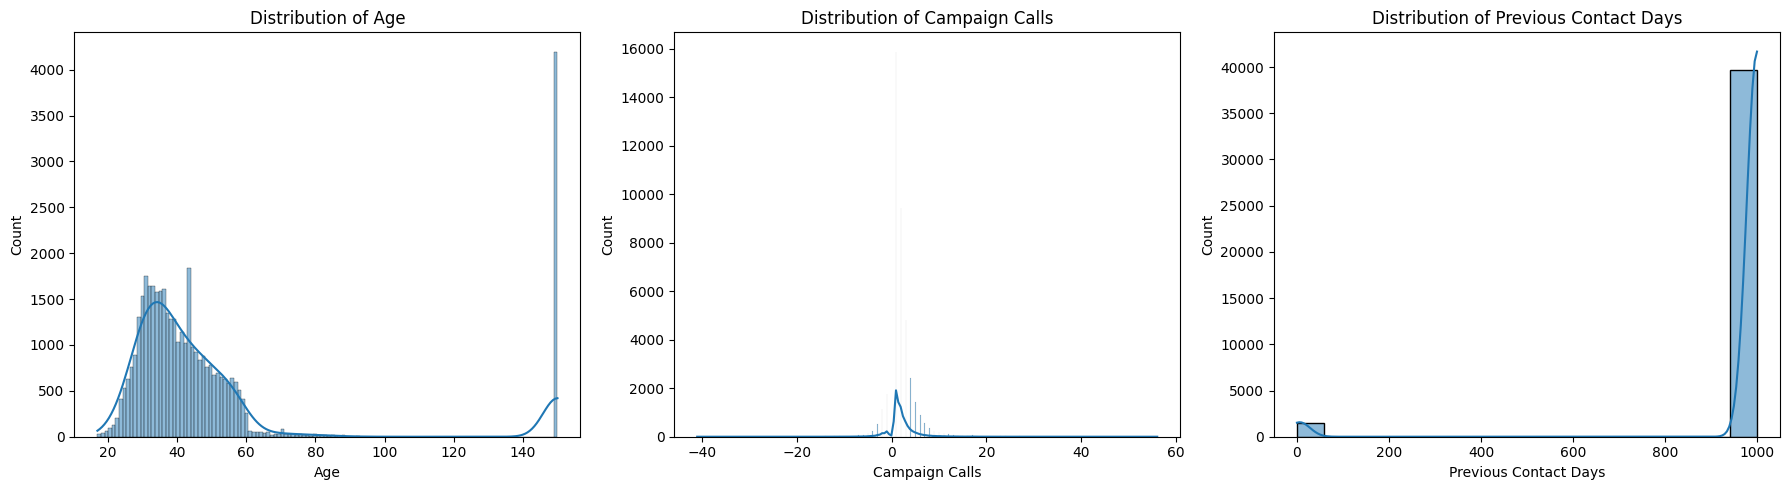

In [ ]:

# Create subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot each chart in its subplot
for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()


✅ **Distribution of Age:**
The age distribution is left-skewed, with most clients between \~20–60 years old. There is a suspicious spike at the maximum value (\~150).
---

✅ **Distribution of Campaign Calls:**
Most clients received fewer than 5 campaign calls, with a long tail extending to higher values. Negative or zero values in the plot may indicate data entry issues that need to be addressed.

---

✅ **Distribution of Previous Contact Days:**
The majority of records are clustered at a high value (\~999), which likely represents a placeholder for "no previous contact."

---


## Distributions of Categorical Features


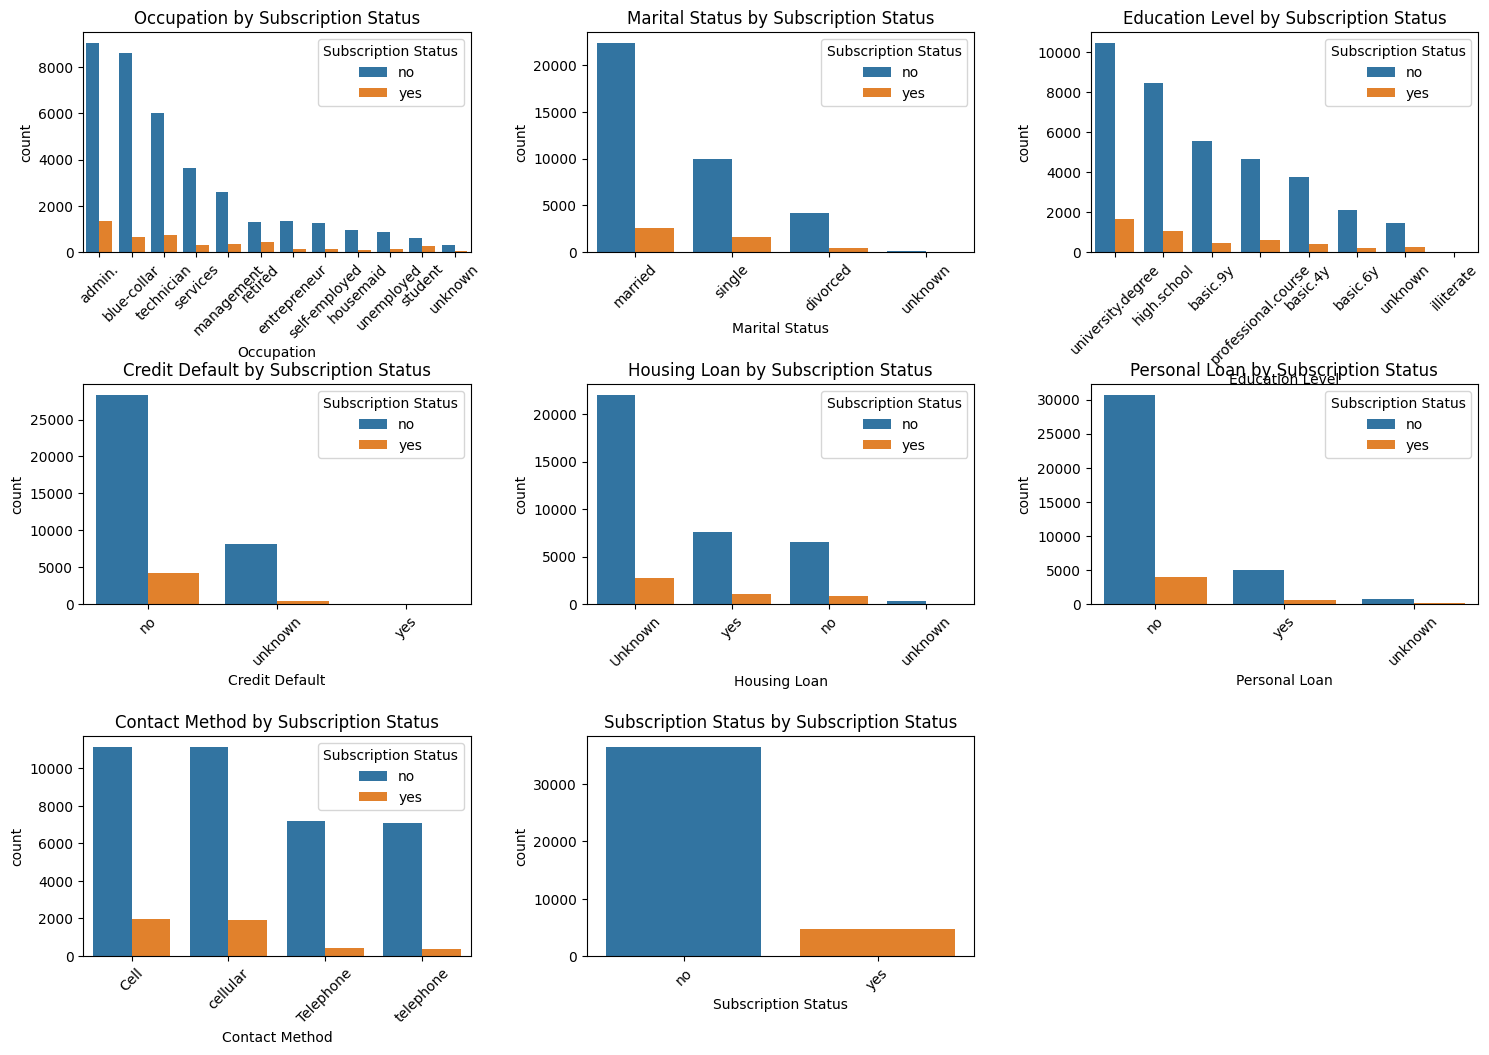

In [ ]:
cat_cols = df.select_dtypes(include=['category']).columns
cat_cols = [col for col in cat_cols if col != 'Client ID']

n_cols = 3  # Number of plots per row
n_rows = int(np.ceil(len(cat_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = np.array(axes).reshape(-1)

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, hue='Subscription Status', data=df, ax=axes[i], order=df[col].value_counts().index)
    axes[i].set_title(f'{col} by Subscription Status')
    axes[i].tick_params(axis='x', rotation=45)

# Remove empty subplots if cat_cols is not a multiple of n_cols
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.subplots_adjust(wspace=0.3, hspace=0.6)
plt.show()


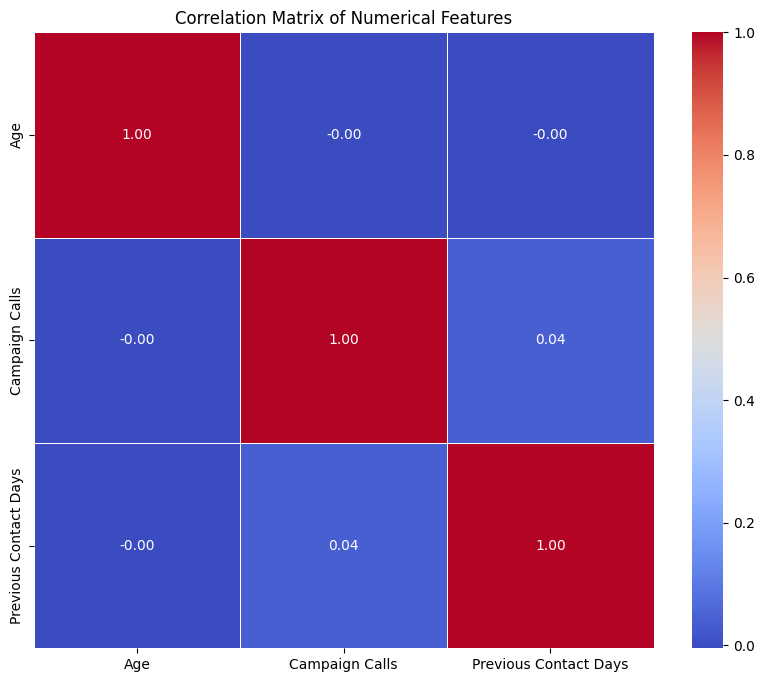

In [ ]:
# 📊 Calculate correlation matrix for numerical features
corr_matrix = df[num_cols].corr()

# 📊 Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


In [ ]:
# Temporarily encode target
df['Subscription_Num'] = df['Subscription Status'].apply(lambda x: 1 if x == 'yes' else 0)

# Add correlation with target
corr_with_target = df[num_cols].corrwith(df['Subscription_Num']).sort_values(ascending=False)
print("\n✅ Correlation of numerical features with Subscription Status:\n", corr_with_target)

# Drop temporary column
df.drop(columns='Subscription_Num', inplace=True)



✅ Correlation of numerical features with Subscription Status:
 Age                      0.002641
Campaign Calls          -0.040544
Previous Contact Days   -0.324914
dtype: float64


### Correlation Matrix

| Pair                                   | Correlation        |
| -------------------------------------- | ------------------ |
| Age ↔ Campaign Calls                   | \~0                |
| Age ↔ Previous Contact Days            | \~0                |
| Campaign Calls ↔ Previous Contact Days | \~0.04 (very weak) |

**Observation:**
There is no meaningful linear correlation between numerical features — they are largely independent of each other.
This is actually good: they bring **non-redundant information** into the model.

---

### Correlation with Target (Subscription Status)

| Feature               | Correlation with Subscription             |
| --------------------- | ----------------------------------------- |
| Age                   | \~0.002 → no correlation                  |
| Campaign Calls        | \~-0.048 → very weak negative correlation |
| Previous Contact Days | \~-0.325 → moderate negative correlation  |

✅ **Key insight:**

* `Previous Contact Days` has the most noticeable relationship with subscription:

  * **Negative correlation** → as days since last contact increase, likelihood of subscription decreases.
  * This suggests **recency of contact matters** — an important insight for feature engineering and modeling.
* `Campaign Calls` and `Age` show **almost no linear relationship** with subscription — but they might still interact **nonlinearly** (worth checking with tree models later).

## Chi-square Test on Categorical Features

The chi-square test helps assess whether categorical features (like Occupation, Marital Status, and Education Level) are significantly associated with the target variable, Subscription Status. This test is crucial because it highlights which categorical variables carry predictive power and may influence subscription outcomes. Features with low p-values (typically < 0.05) show statistically significant relationships and are strong candidates for inclusion in modeling, while non-significant features may require more careful evaluation or may be excluded.

In [ ]:
from scipy.stats import chi2_contingency

for col in cat_cols:
    if col != 'Subscription Status':
        contingency = pd.crosstab(df[col], df['Subscription Status'])
        chi2, p, dof, ex = chi2_contingency(contingency)
        print(f"{col}: p-value = {p:.4f}")


Occupation: p-value = 0.0000
Marital Status: p-value = 0.0000
Education Level: p-value = 0.0000
Credit Default: p-value = 0.0000
Housing Loan: p-value = 0.1537
Personal Loan: p-value = 0.5487
Contact Method: p-value = 0.0000


The categorical features Occupation, Marital Status, Education Level, Credit Default, and Contact Method all show strong and statistically significant associations with Subscription Status (p-value = 0.0000), meaning they are likely important predictors.

In contrast, Housing Loan (p ≈ 0.15) and Personal Loan (p ≈ 0.55) show no significant association with subscription, suggesting they may carry less predictive value, although nonlinear effects can still be explored during modeling.

## Class Balance Check

Evaluating the proportion of each class in Subscription Status helps us understand whether the dataset is balanced or skewed. In this case, the target is highly imbalanced, with nearly 89% “no” and only 11% “yes” responses. This imbalance is important to address in modeling because standard algorithms may favor the majority class, leading to misleading accuracy. We will need to consider strategies like stratified sampling, class weighting, or resampling to handle this effectively during model development.

In [ ]:
df['Subscription Status'].value_counts(normalize=True)

,proportion
Subscription Status,
no,0.887346
yes,0.112654


The target variable is highly imbalanced, with ~89% “no” and ~11% “yes.” This imbalance raises the risk of biased models that overpredict the majority class. We will need to apply techniques like stratified splitting, class weighting, or resampling to ensure fair and meaningful predictions.

Let's finally conclude the Exploratory Data Analysis with some interactive graphs to show the correlation between different variables.

In [ ]:
import plotly.express as px

# Example: Campaign Calls vs. Age colored by Subscription Status
fig = px.scatter(df, x='Age', y='Campaign Calls', color='Subscription Status',
                 hover_data=['Occupation', 'Marital Status'],
                 title='Campaign Calls vs. Age colored by Subscription Status')
fig.show()
